<a href="https://colab.research.google.com/github/christianlehre/Unibo-Deep-Learning/blob/master/DeepLearning_Project3_CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



**Import useful modules**


In [2]:
import os
import math
import numpy as np 
import pandas as pd 
import seaborn as sns
sns.set()
from matplotlib import pyplot as plt
from scipy.linalg import sqrtm
from skimage.transform import resize
from zipfile import ZipFile
import cv2
from PIL import Image

from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Reshape, Concatenate, Lambda, Layer
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import mean_squared_error, binary_crossentropy
from keras import backend as K
from keras import metrics
from keras.applications.inception_v3 import preprocess_input, InceptionV3
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.utils.vis_utils import plot_model
from keras.applications.inception_v3 import InceptionV3



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Mount google drive to notebook**

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# CVAE class

In [4]:
class CVAE():
  def __init__(self,width,height,n_attributes):
    self.width = width
    self.height = height
    self.img_shape = (self.width, self.height, 3)
    self.n_attributes = n_attributes
    
    self.train = False
    self.learning_rate = 0.0005
    self.latent_dim = 100
    self.batch_size = 128
    self.epochs = 100
    self.n_images = 202599

    self.drive_folder = "gdrive/My Drive/dataset_DL"
    self.celeba_zip = "img_align_celeba.zip"
    self.celeba_folder = "img_align_celeba"
    self.attributes_csv = "list_attr_celeba.csv"
    self.attributes_txt = "list_attr_celeba.txt"

    self.vae,self.encoder,self.decoder = self.create_vae()
    self.training_set = self.dataset_generator()
    self.validation_set = self.validation_set_generator()


  def create_encoding_block(self,x):
    x = Conv2D(filters = 32,kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    x = Conv2D(filters = 64,kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    x = Conv2D(filters = 128,kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    x = Conv2D(filters = 256,kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)

    return x


  def create_decoding_block(self,x):
    x = Conv2DTranspose(filters = 128,kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    x = Conv2DTranspose(filters = 64,kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    x = Conv2DTranspose(filters = 32,kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    x = Conv2DTranspose(filters = 3,kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)

    return x


  def create_vae(self):
    input_image = Input(shape = self.img_shape)
    input_attributes = Input(shape = (self.n_attributes,))
    
    enc = self.create_encoding_block(input_image)
    shape_before_flattening = K.int_shape(enc)[1:]
    
    x = Flatten()(enc)
    
    z_mean = Dense(self.latent_dim)(x)
    z_log_sigma = Dense(self.latent_dim)(x)
    z = z_mean + K.exp(0.5*z_log_sigma)*K.random_normal(shape = (K.shape(z_mean)[0],K.shape(z_mean)[1]))
    
    zy = Concatenate()([z,input_attributes])
    
    inputs_embedding = Input(shape = (self.latent_dim + self.n_attributes,))
    embedding = Dense(np.prod(shape_before_flattening))(inputs_embedding)
    embedding = Reshape(shape_before_flattening)(embedding)
    
    x_hat = self.create_decoding_block(embedding)
    
    encoder = Model(inputs = [input_image, input_attributes],outputs = zy)
    decoder = Model(inputs = inputs_embedding,outputs = x_hat)
    
    vae_output = decoder(encoder([input_image,input_attributes]))
    
    generative_loss = np.prod(self.img_shape)*binary_crossentropy(Flatten()(input_image),Flatten()(vae_output))
    latent_loss = -0.5*K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma),axis = -1) 
    vae_loss = K.mean(generative_loss + latent_loss)
    vae = Model(inputs = [input_image, input_attributes], outputs = vae_output)
    vae.add_loss(vae_loss)

    optimizer = Adam(learning_rate = self.learning_rate)
    vae.compile(optimizer)

    return vae, encoder, decoder


  def dataset_generator(self):
    attributes = pd.read_csv(self.drive_folder + "/" + self.attributes_txt, skiprows = 2, header = None, delim_whitespace = True)
    attributes = np.array(attributes)
    with ZipFile(self.drive_folder + "/" + self.celeba_zip,"r") as img_celeba:
      while True:
        images = attributes[np.random.choice(attributes.shape[0],self.batch_size,replace = False)]
        images_batch = []
        attributes_batch = []
        for img_info in images:
          image = cv2.imdecode(np.frombuffer(img_celeba.read(self.celeba_folder + "/" + img_info[0]),np.uint8),cv2.IMREAD_COLOR)[...,::-1]/255.0
          image = np.array(image)
          image_cropped = image[45:173,25:153] 
          image_reshaped = cv2.resize(src = image_cropped, dsize = (self.width, self.height))
          images_batch += [image_reshaped]
          attributes_batch += [img_info[1:]]
        images_batch = np.array(images_batch,dtype = "float32")
        attributes_batch = np.array(attributes_batch,dtype = "int32")

        yield [images_batch,attributes_batch], None


  def validation_set_generator(self):
    attributes = pd.read_csv(self.drive_folder + "/" + self.attributes_txt, skiprows = 2, header = None, delim_whitespace = True)
    attributes = np.array(attributes)
    with ZipFile(self.drive_folder + "/" + self.celeba_zip,"r") as img_celeba:
      batched = 0
      while batched < 10000:
        images = attributes[batched: batched + self.batch_size]
        images_batch = []
        attributes_batch = []
        for img_info in images:
          image = cv2.imdecode(np.frombuffer(img_celeba.read(self.celeba_folder + "/" + img_info[0]),np.uint8),cv2.IMREAD_COLOR)[...,::-1]/255.0
          image = np.array(image)
          image_cropped = image[45:173,25:153]
          image_reshaped = cv2.resize(src = image_cropped, dsize = (self.width, self.height))
          images_batch += [image_reshaped]
          attributes_batch += [img_info[1:]]
        images_batch = np.array(images_batch,dtype = "float32")
        attributes_batch = np.array(attributes_batch,dtype = "int32")

        batched += self.batch_size
        yield [images_batch,attributes_batch]


  def train_model(self):
    checkpoint_filepath = self.drive_folder + "/checkpoints/weights.{epoch:02d}.h5"
    model_checkpoint_callback = ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_freq = 10*self.n_images//self.batch_size,
      save_weights_only = True) 
    callback_list = [model_checkpoint_callback]

    self.vae.fit(self.training_set,steps_per_epoch = self.n_images//self.batch_size,verbose = 1, epochs = self.epochs,callbacks = callback_list)
    self.vae.save_weights(self.drive_folder + "/cvae.h5")
    self.decoder.save_weights(self.drive_folder + "/decoder.h5")
    self.encoder.save_weights(self.drive_folder + "/encoder.h5")


  def calculate_fid_score_generation(self, labels):
    def scale_images(images, new_size):
      new_images = []
      for image in images:
        new_image = resize(image, new_size, order = 1)
        new_images.append(new_image)
      return np.array(new_images)

    def fid_score_equation(activations_1, activations_2):
      mu_1, sigma_1 = activations_1.mean(axis = 0), np.cov(activations_1, rowvar = False)
      mu_2, sigma_2 = activations_2.mean(axis = 0), np.cov(activations_2, rowvar = False)

      ss_diff = np.sum((mu_1 - mu_2)**2)
      cov_mean = sqrtm(sigma_1.dot(sigma_2))

      if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real

      return ss_diff + np.trace(sigma_1 + sigma_2 - 2*cov_mean)

    image_activations = np.reshape([], (0, 2048))
    pred_activations = np.reshape([], (0, 2048))
    incept_model = InceptionV3(include_top = False, pooling = 'avg', input_shape = (299, 299, 3))
    validation_set = self.validation_set_generator()

    z_sample = np.random.randn(10000, self.latent_dim)
    z = np.concatenate((z_sample, labels), axis = 1)

    i = 0
    for batch in validation_set:
      images = batch[0]
      real_images = scale_images(images, (299, 299, 3))
      real_images = preprocess_input(real_images * 255)
      image_activations = np.concatenate((image_activations, incept_model.predict(real_images)), axis = 0)

      predictions = self.decoder.predict(z[i: i + self.batch_size])
      pred_images = scale_images(predictions * 255, (299, 299, 3))
      pred_images = preprocess_input(pred_images)
      pred_activations = np.concatenate((pred_activations, incept_model.predict(pred_images)), axis = 0)

      i += self.batch_size
    
    return fid_score_equation(pred_activations, image_activations)

  def calculate_fid_score_recontruction(self):
    def scale_images(images, new_size):
      new_images = []
      for image in images:
        new_image = resize(image, new_size, order = 1)
        new_images.append(new_image)
      return np.array(new_images)
    def fid_score_equation(activations_1, activations_2):
      mu_1, sigma_1 = activations_1.mean(axis = 0), np.cov(activations_1, rowvar = False)
      mu_2, sigma_2 = activations_2.mean(axis = 0), np.cov(activations_2, rowvar = False)

      ss_diff = np.sum((mu_1 - mu_2)**2)
      cov_mean = sqrtm(sigma_1.dot(sigma_2))

      if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real

      return ss_diff + np.trace(sigma_1 + sigma_2 - 2*cov_mean)

    image_activations = np.reshape([], (0, 2048))
    pred_activations = np.reshape([], (0, 2048))
    incept_model = InceptionV3(include_top = False, pooling = 'avg', input_shape = (299, 299, 3))
    validation_set = self.validation_set_generator()

    for batch in validation_set:
      images = batch[0]
      real_images = scale_images(images, (299, 299, 3))
      real_images = preprocess_input(real_images * 255)
      image_activations = np.concatenate((image_activations, incept_model.predict(real_images)), axis = 0)
      predictions = self.vae.predict(batch)
      pred_images = scale_images(predictions * 255, (299, 299, 3))
      pred_images = preprocess_input(pred_images)
      pred_activations = np.concatenate((pred_activations, incept_model.predict(pred_images)), axis = 0)

    return fid_score_equation(pred_activations, image_activations)


  

# Visualizing results

In [5]:
def plot_batch(images):
  plt.figure(figsize=(10,10))
  for n in range(25):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(array_to_img(images[n,:]))
    plt.axis('off')

def reconstruct_images(model): 
  batch = next(model.validation_set)
  reconstructions = model.vae.predict(batch)
  images = batch[0]
    
  plot_batch(images)
  plt.suptitle('Original images')
  plot_batch(reconstructions)
  plt.suptitle('Reconstructions')


def make_predictions(model):
  z_sample = np.random.randn(model.batch_size, cvae.latent_dim).astype(np.float32)
  label = np.full(shape=(model.batch_size,cvae.n_attributes), fill_value=-1, dtype=np.int32)
  label[:,39] = 1 # Young
  label[:,2] = 1 # Attractive
  label[:,24] = 1 # No_beard


  z = np.concatenate((z_sample, label), axis=1)
  predictions = model.decoder.predict(z)
  plot_batch(predictions)
  plt.suptitle('Predictions')

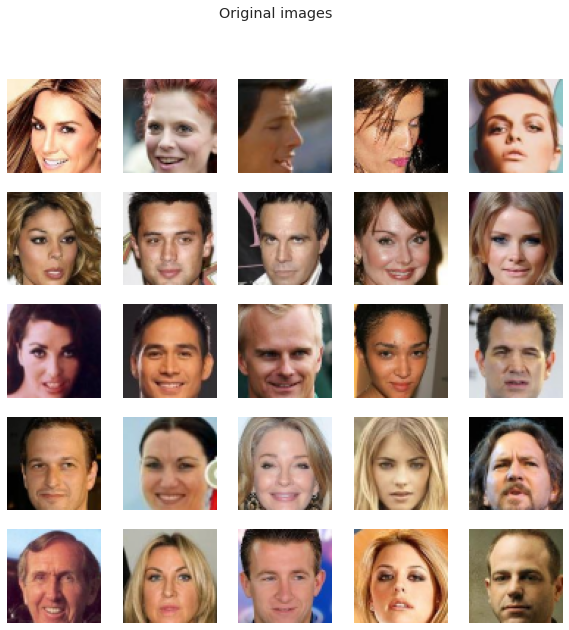

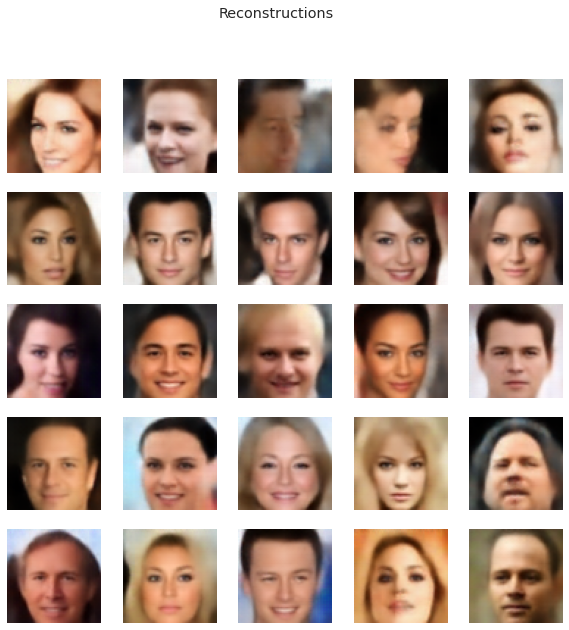

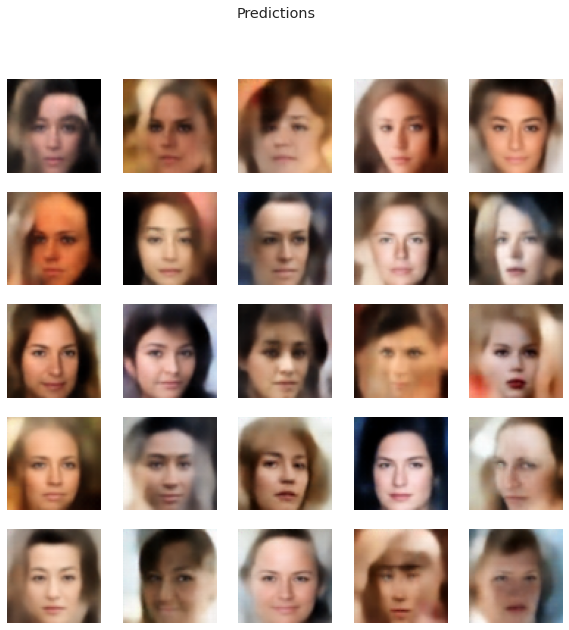

In [6]:
width,height,n_attributes = (64,64,40)
cvae = CVAE(width,height,n_attributes)

if cvae.train:
  history = cvae.train_model()
  cvae.train = False
  plt.figure(figsize = (10,10))
  plt.plot(history.history['loss'])
  plt.title('Model loss during training')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.savefig(cvae.drive_folder + "/figures/training_loss.png")

else:
  cvae.vae.load_weights(cvae.drive_folder + "/cvae.h5")
  cvae.decoder.load_weights(cvae.drive_folder + "/decoder.h5")

  reconstruct_images(cvae)
  make_predictions(cvae)





**histogram of attributes**

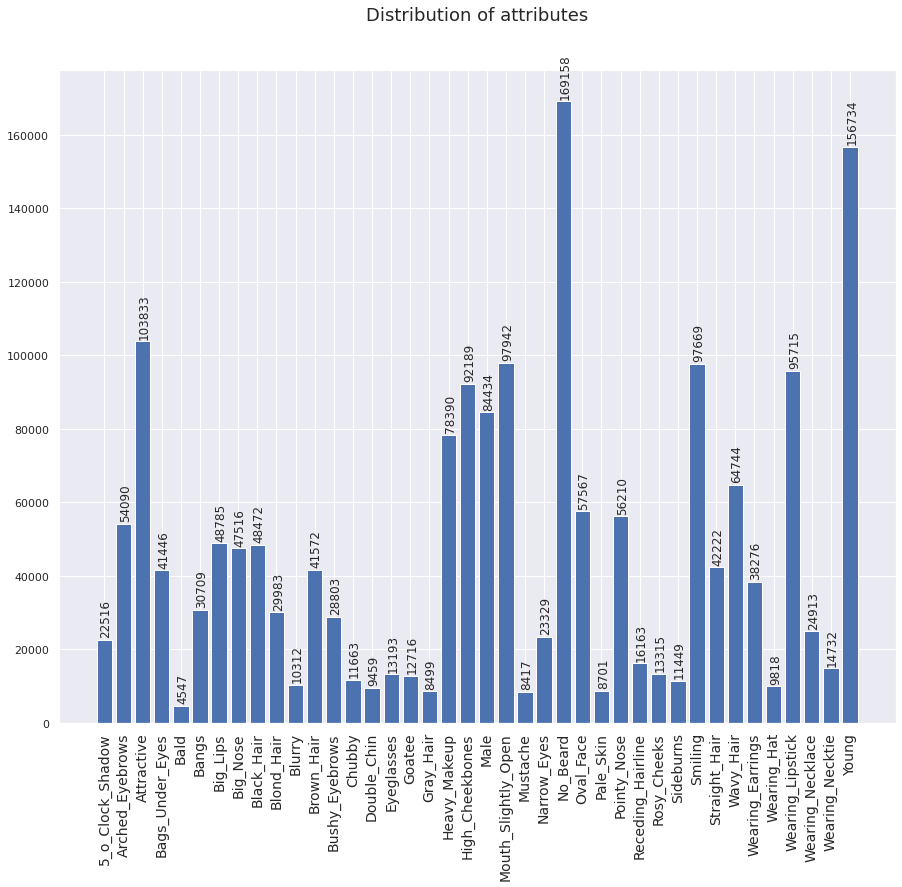

In [7]:
attr = pd.read_csv("gdrive/My Drive/dataset_DL/list_attr_celeba.csv")
attr.replace(-1,0,inplace = True)
attr.set_index('image_id',inplace = True)
attr = attr.astype('int32')

attribute_count_dict = {k:0 for k in attr.columns}
for col in attr.columns: 
  attribute_count_dict[col] = sum(attr[col])

vals = [val for _,val in attribute_count_dict.items()]
keys = [key for key,_ in attribute_count_dict.items()]

plt.figure(figsize = (15,12))
plt.bar(x = keys, height = vals,tick_label = keys)
plt.xticks(keys,rotation = 'vertical',fontsize = 14)
plt.title('Distribution of attributes',fontsize = 18,pad = 50)

xlocs=[i+0.25 for i in range(40)]
for i, v in enumerate(vals):
    plt.text(xlocs[i] - 0.5, v +1500 , str(v),rotation = 'vertical')

#plt.savefig('gdrive/My Drive/dataset_DL/figures/attributes_distribution.png')


**visualize the training progress**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


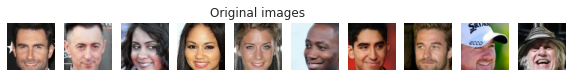

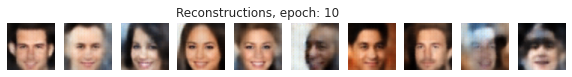

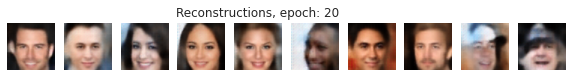

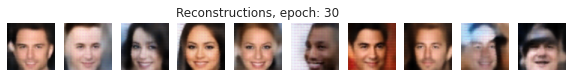

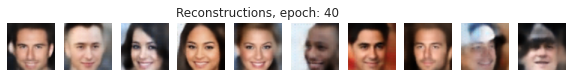

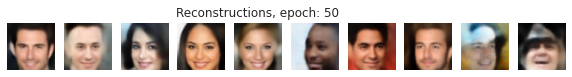

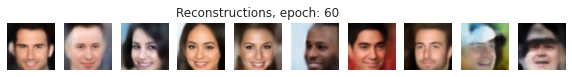

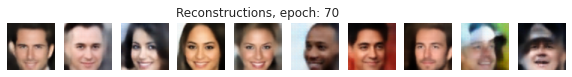

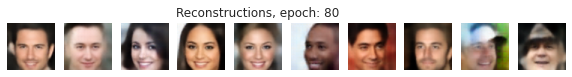

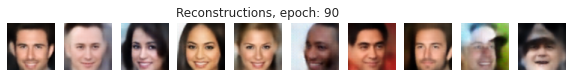

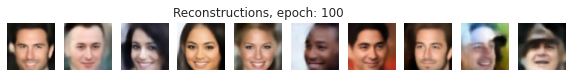

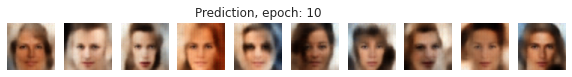

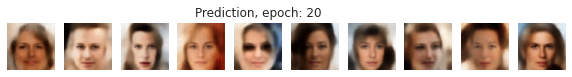

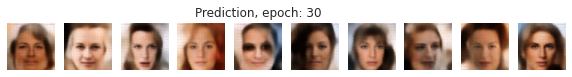

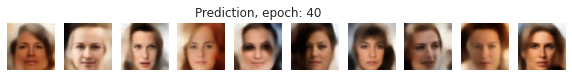

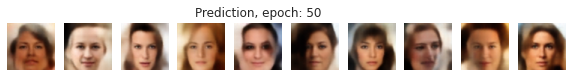

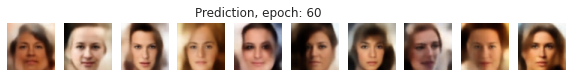

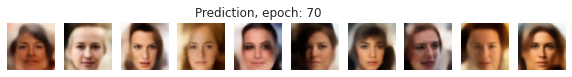

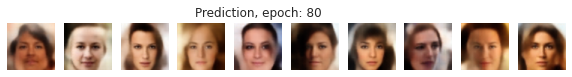

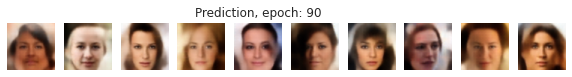

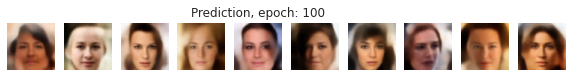

In [8]:
def plot_single(images, title):
  plt.figure(figsize = (len(images), 2))
  i = 0
  for img in images:
    ax = plt.subplot(1,len(images),i+1)
    plt.imshow(array_to_img(images[i,:]))
    plt.axis('off')
    if i == np.floor(np.mean(range(len(images)))):
      plt.title(title)
    i+= 1
  #path_to_fig = "gdrive/My Drive/dataset_DL/figures/Reconstructions/" + title
  #plt.savefig(path_to_fig)


def progress_reconstructions(model,num_images):
  batch = next(model.validation_set)
  original_image = batch[0][0:num_images]
  plot_single(original_image,title = "Original images")

  checkpoints = os.listdir(model.drive_folder + "/checkpoints")
  for chkpt in checkpoints:
    epoch = eval(chkpt.split(".")[1]) - 1
    title = "Reconstructions, epoch: %d" %epoch
    
    path_to_checkpoint = model.drive_folder + "/checkpoints/" + chkpt
    model.vae.load_weights(path_to_checkpoint)
    reconstructions = model.vae.predict(batch)
    plot_single(reconstructions[0:num_images],title = title)
  model.vae.load_weights(model.drive_folder + "/cvae.h5")
  reconstructions = model.vae.predict(batch)
  plot_single(reconstructions[0:num_images],title = "Reconstructions, epoch: 100")


def progress_predictions(model,num_images):
  z_sample = np.random.randn(num_images, model.latent_dim).astype(np.float32)
  label = np.full(shape=(num_images,model.n_attributes), fill_value=-1, dtype=np.int32)
  label[:,2] = 1 # Attractive
  label[:,24] = 1 # Young
  label[:,39] = 1 # No_Beard
  #label[:,15] = 1 #Eyeglasses
  #label[:,4] = 1 # Bald
  #label[:,22] = 1 # Mustache

  z = np.concatenate((z_sample, label), axis=1)

  checkpoints = os.listdir(model.drive_folder + "/checkpoints")
  for chkpt in checkpoints:
    epoch = eval(chkpt.split(".")[1]) - 1
    title = "Prediction, epoch: %d" %epoch
    
    path_to_checkpoint = model.drive_folder + "/checkpoints/" + chkpt
    model.vae.load_weights(path_to_checkpoint)
    prediction = model.decoder.predict(z)
    plot_single(prediction[0:num_images],title = title)
  model.vae.load_weights(model.drive_folder + "/cvae.h5")
  prediction = model.decoder.predict(z)
  plot_single(prediction[0:num_images],title = "Prediction, epoch: 100")


  
progress_reconstructions(cvae,10)
progress_predictions(cvae,10)




**Calculating the FID score**

In [9]:
width, height, n_attributes = (64, 64, 40)
cvae = CVAE(width, height, n_attributes)

def progress_fid_score_generation(labels):
  fid_scores = []
  for i in range(1, 10):
    cvae.vae.load_weights(cvae.drive_folder + "/checkpoints/weights." + str(i) + "1.h5")
    fid_scores.append(cvae.calculate_fid_score_generation(labels))
    print("FID score (generation) after " + str(i*10) + " epochs: ", fid_scores[-1])

  cvae.vae.load_weights(cvae.drive_folder + "/cvae.h5")
  fid_scores.append(cvae.calculate_fid_score_generation(labels))
  print("FID score (generation) after 100 epochs, i.e. the final score: ", fid_scores[-1])

  return fid_scores

def progress_fid_score_reconstruction():
  fid_scores = []
  for i in range(1,10):
    cvae.vae.load_weights(cvae.drive_folder + "/checkpoints/weights." + str(i)+ "1.h5")
    fid_scores.append(cvae.calculate_fid_score_recontruction())
    print("FID score (reconstruction) after " + str(i*10) + "epochs: ", fid_scores[-1])
  cvae.vae.load_weights(cvae.drive_folder + "/cvae.h5")
  fid_scores.append(cvae.calculate_fid_score_recontruction())
  print("FID score (reconstruction) after 100 epochs, i.e the final score: ", fid_scores[-1])
  return fid_scores

In [10]:
labels = - np.ones((10000, n_attributes))
labels[:, 2] = 1  # attractive
labels[:, 39] = 1  # young
labels[:, 24] = 1  # no beard

print("The progress of the FID score for labels no_beard, attractive and young:")
fid_scores_most = progress_fid_score_generation(labels)

The progress of the FID score for labels no_beard, attractive and young:
87916544/87910968 [==============================] - 1s 0us/step
FID score (generation) after 10 epochs:  127.1931161698269
FID score (generation) after 20 epochs:  89.6557439129324
FID score (generation) after 30 epochs:  117.02167831604001
FID score (generation) after 40 epochs:  86.65071044095049
FID score (generation) after 50 epochs:  86.28492819500994
FID score (generation) after 60 epochs:  87.25536454764699
FID score (generation) after 70 epochs:  85.28761980587507
FID score (generation) after 80 epochs:  89.32031045616674
FID score (generation) after 90 epochs:  83.68245280905856
FID score (generation) after 100 epochs, i.e. the final score:  85.77600821097721


In [12]:
labels = - np.ones((10000, n_attributes))
labels[:, 4] = 1  # bald
labels[:, 15] = 1  # eyeglasses
labels[:, 22] = 1  # mustache

print("The progress of the FID score for labels bald, eyeglasses and mustache:")
fid_scores_least = progress_fid_score_generation(labels)

The progress of the FID score for labels bald, eyeglasses and mustache:
FID score (generation) after 10 epochs:  142.80699278486114
FID score (generation) after 20 epochs:  94.389326048843
FID score (generation) after 30 epochs:  118.00573436554086
FID score (generation) after 40 epochs:  81.64676567769092
FID score (generation) after 50 epochs:  80.07261083753815
FID score (generation) after 60 epochs:  83.44242019905947
FID score (generation) after 70 epochs:  79.65018670109869
FID score (generation) after 80 epochs:  85.32846195063627
FID score (generation) after 90 epochs:  79.71083820194099
FID score (generation) after 100 epochs, i.e. the final score:  79.01559422941145


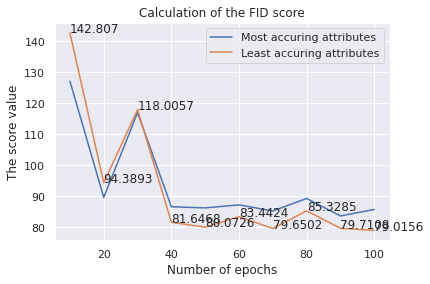

In [13]:
x = np.arange(10, 110, 10)

plt.figure()
plt.plot(x, fid_scores_most, label = "Most accuring attributes")
plt.plot(x, fid_scores_least, label = "Least accuring attributes")
for a, b in zip(x, np.round(fid_scores_least, 4)): 
    plt.text(a, b, str(b))
plt.title("Calculation of the FID score")
plt.xlabel("Number of epochs")
plt.ylabel("The score value")
plt.legend()
plt.show()

FID score (reconstruction) after 10epochs:  91.85143159989875
FID score (reconstruction) after 20epochs:  64.99166450518551
FID score (reconstruction) after 30epochs:  90.14399667822916
FID score (reconstruction) after 40epochs:  58.692067553056354
FID score (reconstruction) after 50epochs:  56.70984887456191
FID score (reconstruction) after 60epochs:  58.33759264649663
FID score (reconstruction) after 70epochs:  56.648298900857654
FID score (reconstruction) after 80epochs:  59.18042707611057
FID score (reconstruction) after 90epochs:  56.26838468346682
FID score (reconstruction) after 100 epochs, i.e the final score:  56.72179712123869


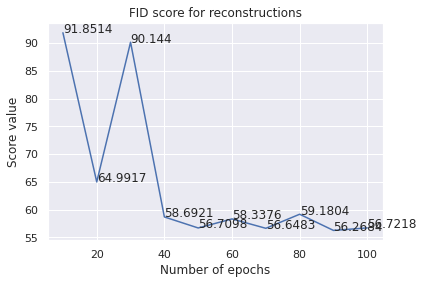

<Figure size 432x288 with 0 Axes>

In [14]:
fid_scores_reconstructions = progress_fid_score_reconstruction()
plt.figure()
x = np.arange(10, 110, 10)
plt.plot(x,fid_scores_reconstructions)
plt.title("FID score for reconstructions")
plt.ylabel("Score value")
plt.xlabel("Number of epochs")
for a, b in zip(x, np.round(fid_scores_reconstructions, 4)): 
    plt.text(a, b, str(b))
plt.show()
plt.savefig(cvae.drive_folder + "/figures/FID_progress_reconstructions.png")